In [1]:
import pandas as pd
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import gpflow
from gpflow.utilities import print_summary
import statsmodels.api as sm

In [2]:
plt.rcParams.update({'font.size': 16})

Monthly Data: San Francisco

In [3]:
df = pd.read_csv('San_Francisco_Monthly.csv')

In [4]:
df = df.rename(columns={'MHHW (m)' :'H(m)'})
df = df.dropna(subset=['H(m)']).reset_index()

In [5]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

start_point = df['Date'].dt.to_period('M').view(dtype='int64')[0] 
df['X'] = df['Date'].dt.to_period('M').view(dtype='int64') - start_point

In [6]:
filt = df['X'] < (df['X'].max()-60)
training = df[filt]
test = df[~filt]
X_train = training['X'].to_numpy()[:,np.newaxis]
y_train = training['H(m)'].to_numpy()
X_test = test['X'].to_numpy()[:,np.newaxis]
y_test = test['H(m)'].to_numpy()

Ridge

In [7]:
scaler = StandardScaler()
poly = PolynomialFeatures(3,include_bias=False)
X_train_poly = scaler.fit_transform(poly.fit_transform(X_train)) 

In [8]:
ridge_mdl = RidgeCV(alphas=np.logspace(1,3,10),fit_intercept=True,cv=TimeSeriesSplit(n_splits=20)) 

In [9]:
ridge_mdl.fit(X_train_poly,y_train)
print(ridge_mdl.alphas)
print(ridge_mdl.alpha_)

[  10.           16.68100537   27.82559402   46.41588834   77.42636827
  129.1549665   215.443469    359.38136638  599.48425032 1000.        ]
215.44346900318823


In [10]:
y_train_pred = ridge_mdl.predict(X_train_poly)
print(f'training error {mean_squared_error(y_train,y_train_pred):.5f}')
y_test_pred = ridge_mdl.predict(scaler.transform(poly.transform(X_test)))
print(f'test error {mean_squared_error(y_test_pred,y_test):.5f}')

training error 0.00742
test error 0.00616


Lasso

In [11]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [12]:
lambda_values = np.logspace(-4,-2,10) 
print(lambda_values)
lassoMdl = LassoCV(alphas=lambda_values,cv=10,max_iter=10000,fit_intercept=True,n_jobs=-1)
lassoMdl.fit(X_train_std, y_train)
print(lassoMdl.alpha_)

[0.0001     0.00016681 0.00027826 0.00046416 0.00077426 0.00129155
 0.00215443 0.00359381 0.00599484 0.01      ]
0.0001


In [13]:
y_pred_train = lassoMdl.predict(X_train_std)
y_pred_test = lassoMdl.predict(X_test_std)
print(mean_squared_error(y_pred_train,y_train))
print(mean_squared_error(y_pred_test,y_test))

0.007372850283685819
0.006156917311155386


Random Forest

In [14]:
n_estimators = [x for x in np.arange(50,400,50)]
max_depth = [x for x in np.arange(1, 30, 5)]
max_depth.append(None)

max_features = list(range(1,7))
max_features.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_features': [1, 2, 3, 4, 5, 6, None], 'max_depth': [1, 6, 11, 16, 21, 26, None]}


In [15]:
rf_random = RandomizedSearchCV(estimator =  RandomForestRegressor(), param_distributions=random_grid, n_iter=200,
                               refit=True, pre_dispatch = 6, cv = 5, verbose=3, n_jobs = -1)

In [16]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 6, 11, 16, 21, 26,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6,
                                                         None],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350]},
                   pre_dispatch=6, verbose=3)

In [17]:
rfMdl = rf_random.best_estimator_

In [18]:
y_pred_test_rf = rfMdl.predict(X_test)
y_pred_train_rf = rfMdl.predict(X_train)
print(mean_squared_error(y_pred_train_rf,y_train))
print(mean_squared_error(y_pred_test_rf,y_test))



0.001683076576840494
0.006196633684348794


Model with lowest training error goes forward

In [19]:
arr = np.linspace(540,600,100)
X_trend = arr[:,np.newaxis]
y_trend = rfMdl.predict(X_trend)

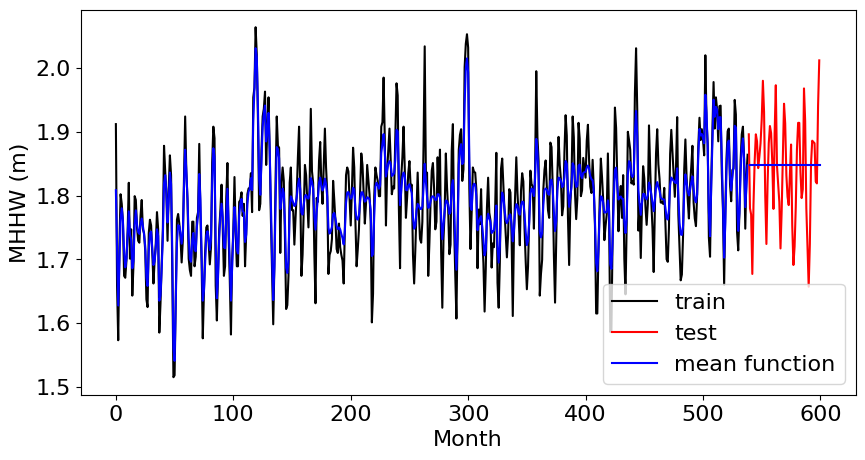

In [20]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_train,y_pred_train_rf,color='blue')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(arr,y_trend,color='blue',label='mean function')
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

In [21]:
residual_train = y_train - y_pred_train_rf
residual_test = y_test - y_pred_test_rf

In [22]:
opt = gpflow.optimizers.Scipy()

In [23]:
k = gpflow.kernels.Exponential(0.1,3) 
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

In [24]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -982.5597005868437
        x: [-5.785e-01 -6.386e+00 -2.243e+01]
      nit: 32
      jac: [ 3.431e-03 -1.268e-03  2.861e-06]
     nfev: 47
     njev: 47
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [25]:
print_summary(gp_mdl)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00168 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.44515 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [26]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00000
test error 0.00619


In [27]:
x_new = np.linspace(0,600,61)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis]) # it returns the mean and std of the GP prediction
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict((x_new[:,np.newaxis]))
mu = trend + residual


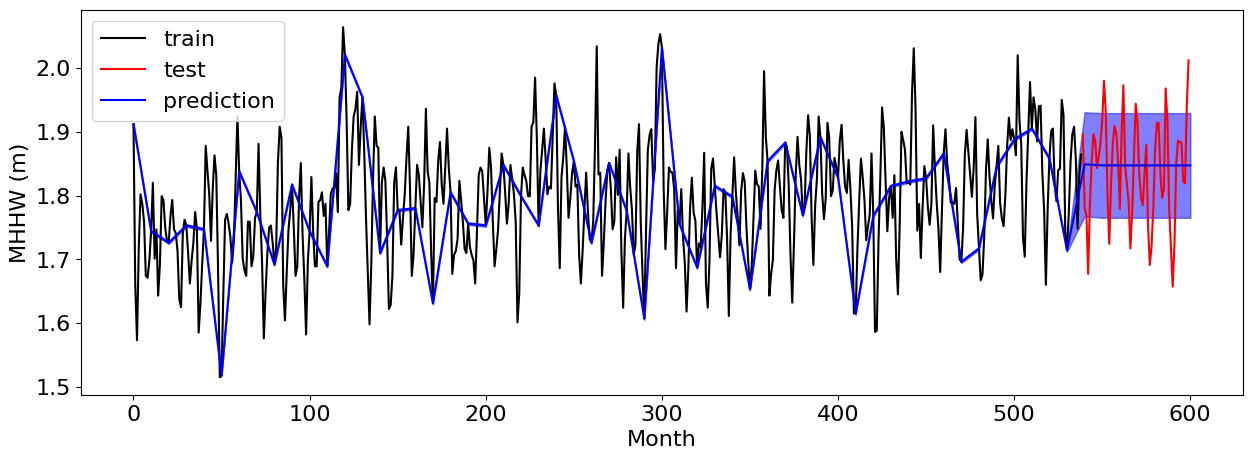

In [28]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5) # show prediction error
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

Second kernel

In [29]:
opt = gpflow.optimizers.Scipy()
k = gpflow.kernels.Periodic(gpflow.kernels.Exponential(0.1,4))
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

In [30]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1107.102309388461
        x: [ 2.492e+00  4.342e+00 -3.814e+00 -7.090e+00]
      nit: 39
      jac: [-4.269e-03  1.291e-01  2.998e-02  3.206e-04]
     nfev: 111
     njev: 111
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [31]:
print_summary(gp_mdl)

╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.02182 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.35475 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.57147 │


In [32]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00080
test error 0.00383


In [33]:
x_new = np.linspace(0,600,100)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis])
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict((x_new[:,np.newaxis]))

mu = trend + residual

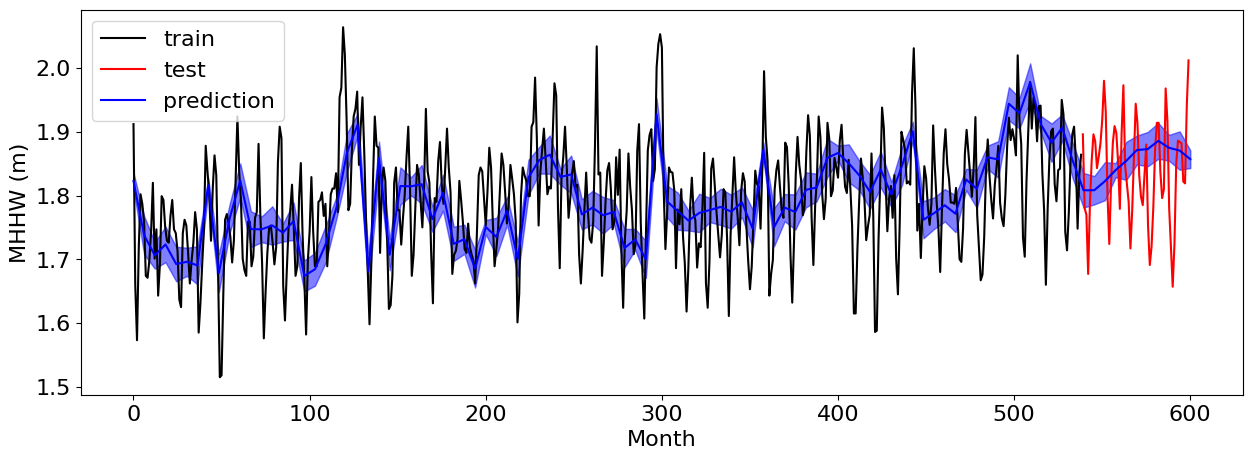

In [34]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

Hourly Data: San Francisco

In [35]:
df = pd.read_csv('San_Francisco_Hourly.csv')

In [36]:
df = df.rename(columns={'Verified (m)' :'H(m)'})
df = df.dropna(subset=['H(m)']).reset_index()
df = df[df['H(m)'] != '-']

In [37]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
#df['Time (GMT)'] = pd.to_time(df['Time (GMT)'], infer_datetime_format=True)

start_point = df['Date'].dt.to_period('D').view(dtype='int64')[0] 
df['I'] = df['Date'].dt.to_period('D').view(dtype='int64') - start_point

#start_point2 = df['Time (GMT)'].dt.to_period('h').view(dtype='int64')[0]
df['J'] = pd.DatetimeIndex(df['Time (GMT)']).hour
df['X'] = df['I'] * 24 + df['J']

In [38]:
filt1 = df['X'] >= (df['X'].max()-72)
filt2 = df['X'] > (df['X'].max()-672)
training = df[filt2]
training = training[~filt1]
test = df[filt1] 
X_train = training['X'].to_numpy()[:,np.newaxis]
y_train = training['H(m)'].astype(float)
X_test = test['X'].to_numpy()[:,np.newaxis]
y_test = test['H(m)'].astype(float)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\2803884468.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  training = training[~filt1]


In [39]:
baseline = X_train[0]

In [40]:
X_train = X_train - baseline

In [41]:
X_test = X_test - baseline

Ridge

In [42]:
scaler = StandardScaler()
poly = PolynomialFeatures(5,include_bias=False)
X_train_poly = scaler.fit_transform(poly.fit_transform(X_train)) 

In [43]:
ridge_mdl = RidgeCV(alphas=np.logspace(.5,10,20),fit_intercept=True,cv=TimeSeriesSplit(n_splits=20)) 

In [44]:
ridge_mdl.fit(X_train_poly,y_train)
print(ridge_mdl.alphas)
print(ridge_mdl.alpha_)

[3.16227766e+00 1.00000000e+01 3.16227766e+01 1.00000000e+02
 3.16227766e+02 1.00000000e+03 3.16227766e+03 1.00000000e+04
 3.16227766e+04 1.00000000e+05 3.16227766e+05 1.00000000e+06
 3.16227766e+06 1.00000000e+07 3.16227766e+07 1.00000000e+08
 3.16227766e+08 1.00000000e+09 3.16227766e+09 1.00000000e+10]
1000.0


In [45]:
y_train_pred = ridge_mdl.predict(X_train_poly)
print(f'training error {mean_squared_error(y_train,y_train_pred):.5f}')
y_test_pred = ridge_mdl.predict(scaler.transform(poly.transform(X_test)))
print(f'test error {mean_squared_error(y_test,y_test_pred):.5f}')

training error 0.33838
test error 0.24972


Lasso

In [46]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
lambda_values = np.logspace(-4,-2,10) 
print(lambda_values)

[0.0001     0.00016681 0.00027826 0.00046416 0.00077426 0.00129155
 0.00215443 0.00359381 0.00599484 0.01      ]


In [47]:
lassoMdl = LassoCV(alphas=lambda_values,cv=10,max_iter=10000,fit_intercept=True,n_jobs=-1)
lassoMdl.fit(X_train_std, y_train)
print(lassoMdl.alpha_)

0.005994842503189409


In [48]:
y_pred_train = lassoMdl.predict(X_train_std)
y_pred_test = lassoMdl.predict(X_test_std)
print(mean_squared_error(y_pred_train,y_train))
print(mean_squared_error(y_pred_test,y_test))

0.3383985664312519
0.22516066591292275


Random Forest

In [49]:
n_estimators = [x for x in np.arange(50,400,50)]
max_depth = [x for x in np.arange(1, 30, 5)]
max_depth.append(None)

In [50]:
max_features = list(range(1,7))
max_features.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_features': [1, 2, 3, 4, 5, 6, None], 'max_depth': [1, 6, 11, 16, 21, 26, None]}


In [51]:
rf_random = RandomizedSearchCV(estimator =  RandomForestRegressor(), param_distributions=random_grid, n_iter=200,
                               refit=True, pre_dispatch = 6, cv = 5, verbose=3, n_jobs = -1)
rf_random.fit(X_train, y_train)
rfMdl = rf_random.best_estimator_
y_pred_test_rf = rfMdl.predict(X_test)
y_pred_train_rf = rfMdl.predict(X_train)
print(mean_squared_error(y_pred_train_rf,y_train))
print(mean_squared_error(y_pred_test_rf,y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.3276733181435046
0.22508881742182144



Model with lowest training error goes forward

In [52]:
arr = np.linspace(600,672,125)
X_trend = arr[:,np.newaxis]
y_trend = rfMdl.predict(X_trend)

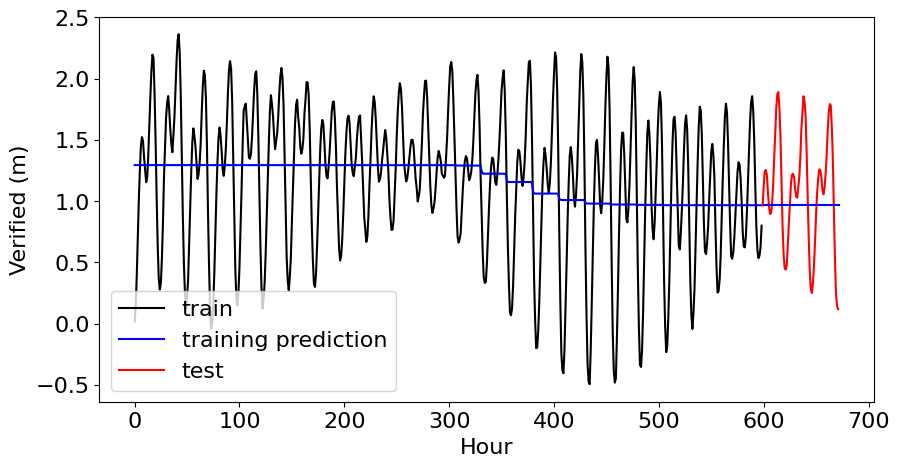

In [53]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_train,y_pred_train_rf,color='b', label = 'training prediction')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(arr,y_trend,color='blue')
ax.set_xlabel('Hour')
ax.set_ylabel('Verified (m)')
ax.legend()

In [54]:
residual_train = y_train - y_pred_train_rf
residual_test = y_test - y_pred_test_rf

In [55]:
opt = gpflow.optimizers.Scipy()

In [56]:
k = gpflow.kernels.Exponential(0.1,3) 
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\2754874951.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)


In [57]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -42.15187962269067
        x: [ 6.130e+00 -9.146e-01 -2.575e+01]
      nit: 37
      jac: [ 1.428e-04 -6.483e-04  6.250e-08]
     nfev: 42
     njev: 42
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [58]:
print_summary(gp_mdl)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.33695 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.13218 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [59]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00000
test error 0.23702


In [60]:
x_new = np.linspace(0,672,125)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis]) # it returns the mean and std of the GP prediction
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict(x_new[:,np.newaxis])
mu = trend + residual

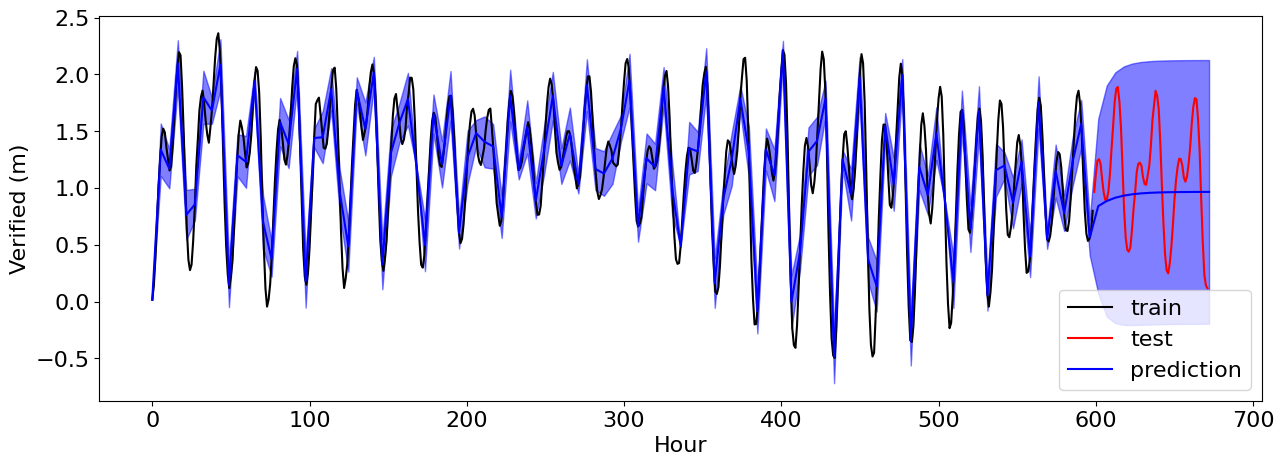

In [61]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5) # show prediction error
ax.set_xlabel('Hour')
ax.set_ylabel('Verified (m)')
ax.legend()

In [62]:
opt = gpflow.optimizers.Scipy()
k = gpflow.kernels.Periodic(gpflow.kernels.Exponential(0.1,4))
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\3834780370.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)


In [63]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 515.7806091003868
        x: [ 1.879e+00  7.452e+00 -1.947e+01 -9.474e-01]
      nit: 27
      jac: [ 1.910e-04  1.306e-08  3.093e-06 -2.473e-04]
     nfev: 45
     njev: 45
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [64]:
print_summary(gp_mdl)

╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0       │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 7.45209 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.02134 │


In [65]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.32767
test error 0.22509


In [66]:
x_new = np.linspace(0,672,125)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis])
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict(x_new[:,np.newaxis])

mu = trend + residual

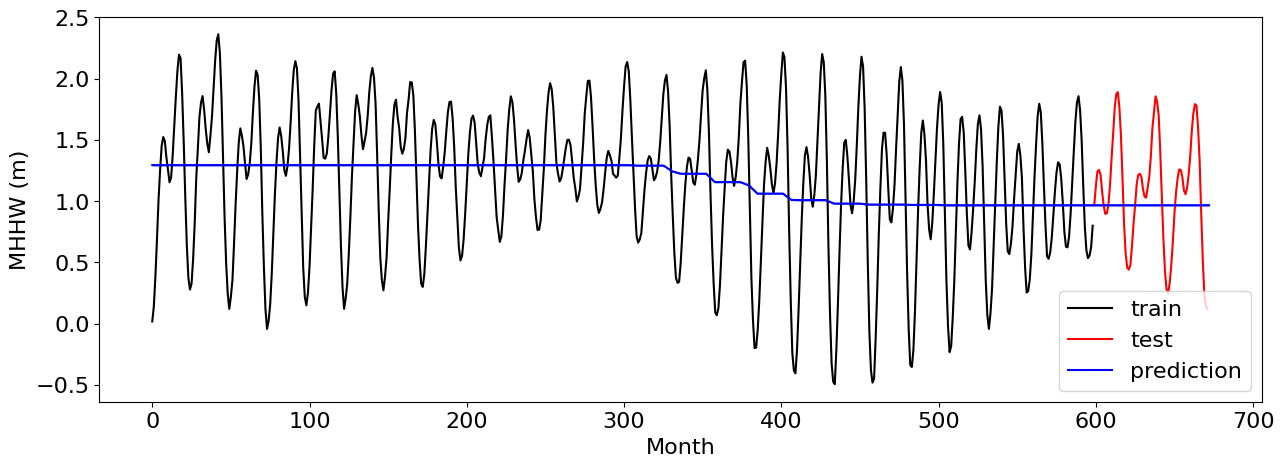

In [67]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

Monthly Data: New York

In [68]:
plt.rcParams.update({'font.size': 14})

In [69]:
df = pd.read_csv('New_York_Monthly.csv')

In [70]:
df = df.rename(columns={'MHHW (m)' :'H(m)'})
df = df.dropna(subset=['H(m)']).reset_index()

In [71]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

start_point = df['Date'].dt.to_period('M').view(dtype='int64')[0] 
df['X'] = df['Date'].dt.to_period('M').view(dtype='int64') - start_point

In [72]:
filt = df['X'] < (df['X'].max()-60)
training = df[filt]
test = df[~filt]
X_train = training['X'].to_numpy()[:,np.newaxis]
y_train = training['H(m)'].to_numpy()
X_test = test['X'].to_numpy()[:,np.newaxis]
y_test = test['H(m)'].to_numpy()

Ridge

In [73]:
scaler = StandardScaler()
poly = PolynomialFeatures(3,include_bias=False)
X_train_poly = scaler.fit_transform(poly.fit_transform(X_train)) 

In [74]:
ridge_mdl = RidgeCV(alphas=np.logspace(1,3,10),fit_intercept=True,cv=TimeSeriesSplit(n_splits=20)) 

In [75]:
ridge_mdl.fit(X_train_poly,y_train)
print(ridge_mdl.alphas)
print(ridge_mdl.alpha_)

[  10.           16.68100537   27.82559402   46.41588834   77.42636827
  129.1549665   215.443469    359.38136638  599.48425032 1000.        ]
27.825594022071243


In [76]:
y_train_pred = ridge_mdl.predict(X_train_poly)
print(f'training error {mean_squared_error(y_train,y_train_pred):.5f}')
y_test_pred = ridge_mdl.predict(scaler.transform(poly.transform(X_test)))
print(f'test error {mean_squared_error(y_test_pred,y_test):.5f}')

training error 0.00660
test error 0.00706


Lasso

In [77]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [78]:
lambda_values = np.logspace(-4,-2,10) 
print(lambda_values)
lassoMdl = LassoCV(alphas=lambda_values,cv=10,max_iter=10000,fit_intercept=True,n_jobs=-1)
lassoMdl.fit(X_train_std, y_train)
print(lassoMdl.alpha_)

[0.0001     0.00016681 0.00027826 0.00046416 0.00077426 0.00129155
 0.00215443 0.00359381 0.00599484 0.01      ]
0.0001


In [79]:
y_pred_train = lassoMdl.predict(X_train_std)
y_pred_test = lassoMdl.predict(X_test_std)
print(mean_squared_error(y_pred_train,y_train))
print(mean_squared_error(y_pred_test,y_test))

0.006793812295921264
0.007992962838327674


Random Forest

In [80]:
n_estimators = [x for x in np.arange(50,400,50)]
max_depth = [x for x in np.arange(1, 30, 5)]
max_depth.append(None)

max_features = list(range(1,7))
max_features.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_features': [1, 2, 3, 4, 5, 6, None], 'max_depth': [1, 6, 11, 16, 21, 26, None]}


In [81]:
rf_random = RandomizedSearchCV(estimator =  RandomForestRegressor(), param_distributions=random_grid, n_iter=200,
                               refit=True, pre_dispatch = 6, cv = 5, verbose=3, n_jobs = -1)

In [82]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 6, 11, 16, 21, 26,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6,
                                                         None],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350]},
                   pre_dispatch=6, verbose=3)

In [83]:
rfMdl = rf_random.best_estimator_

In [84]:
y_pred_test_rf = rfMdl.predict(X_test)
y_pred_train_rf = rfMdl.predict(X_train)
print(mean_squared_error(y_pred_train_rf,y_train))
print(mean_squared_error(y_pred_test_rf,y_test))



0.006403351495201596
0.009225930000963431


Model with lowest training error goes forward

In [85]:
arr = np.linspace(540,600,100)
X_trend = arr[:,np.newaxis]
y_trend = rfMdl.predict(X_trend)

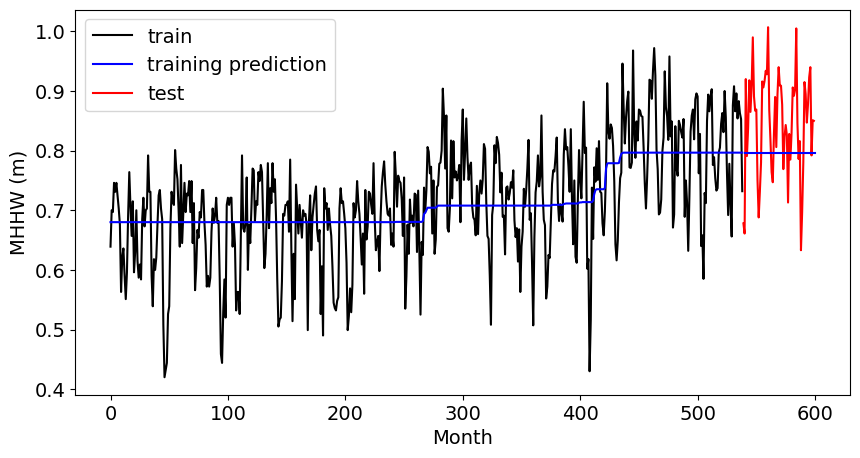

In [86]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_train,y_pred_train_rf,color='blue', label='training prediction')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(arr,y_trend,color='blue')
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

In [87]:
residual_train = y_train - y_pred_train_rf
residual_test = y_test - y_pred_test_rf

In [88]:
opt = gpflow.optimizers.Scipy()

In [89]:
k = gpflow.kernels.Exponential(0.1,3) 
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

In [90]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -713.8193291653762
        x: [ 6.133e-01 -5.093e+00 -8.214e+00]
      nit: 27
      jac: [-1.205e-03  2.790e-03  3.526e-04]
     nfev: 34
     njev: 34
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [91]:
print_summary(gp_mdl)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00612 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.04608 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.00027 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [92]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00002
test error 0.00911


In [93]:
plt.rcParams.update({'font.size': 16})

In [94]:
x_new = np.linspace(0,600,61)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis]) # it returns the mean and std of the GP prediction
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict((x_new[:,np.newaxis]))
mu = trend + residual


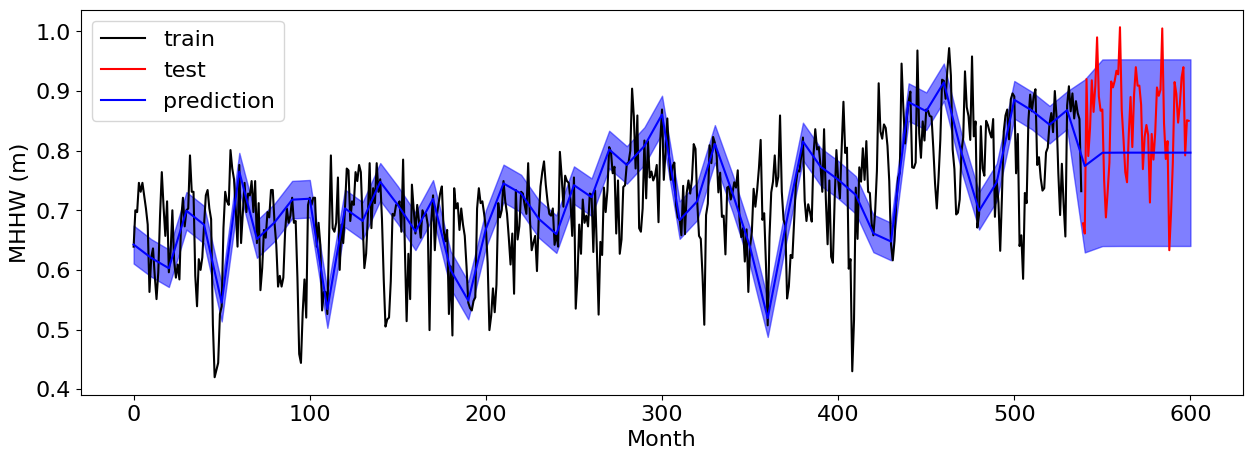

In [95]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5) # show prediction error
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

Second kernel

In [96]:
opt = gpflow.optimizers.Scipy()
k = gpflow.kernels.Periodic(gpflow.kernels.Exponential(0.1,4))
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

In [97]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -642.329143303655
        x: [ 2.131e+00  3.510e+00 -4.861e-01 -5.692e+00]
      nit: 27
      jac: [-6.055e+00  1.594e-01  4.237e-02 -6.377e-04]
     nfev: 83
     njev: 83
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [98]:
print_summary(gp_mdl)

╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.47936 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.539   │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.243   │


In [99]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00262
test error 0.00752


In [100]:
x_new = np.linspace(0,600,100)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis])
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict((x_new[:,np.newaxis]))

mu = trend + residual

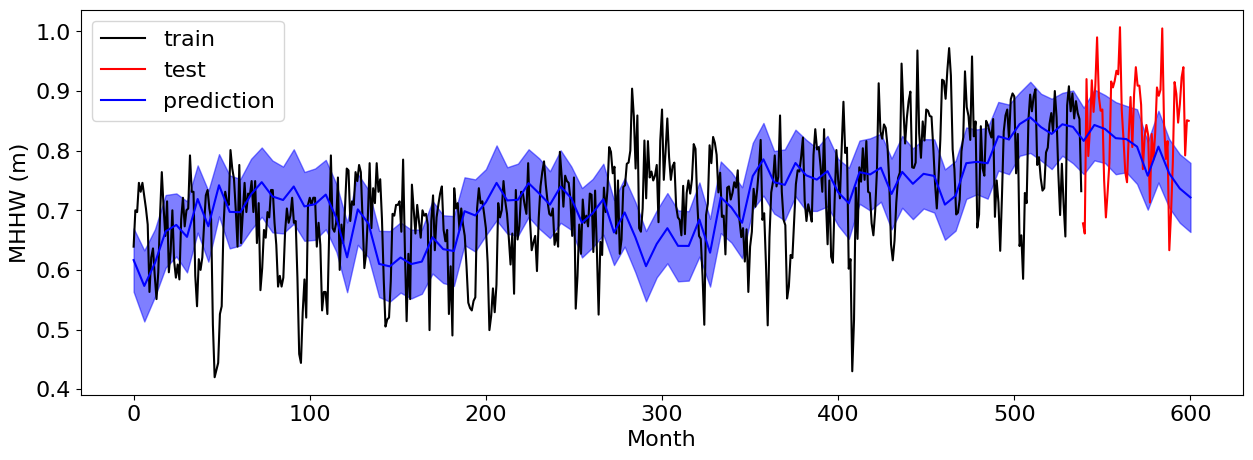

In [101]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()

Hourly Data: New York

In [102]:
plt.rcParams.update({'font.size': 14})

In [103]:
df = pd.read_csv('New_York_Hourly.csv')

In [104]:
df = df.rename(columns={'Verified (m)' :'H(m)'})
df = df.dropna(subset=['H(m)']).reset_index()
df = df[df['H(m)'] != '-']

In [105]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
#df['Time (GMT)'] = pd.to_time(df['Time (GMT)'], infer_datetime_format=True)

start_point = df['Date'].dt.to_period('D').view(dtype='int64')[0] 
df['I'] = df['Date'].dt.to_period('D').view(dtype='int64') - start_point

#start_point2 = df['Time (GMT)'].dt.to_period('h').view(dtype='int64')[0]
df['J'] = pd.DatetimeIndex(df['Time (GMT)']).hour
df['X'] = df['I'] * 24 + df['J']

In [106]:
filt1 = df['X'] >= (df['X'].max()-72)
filt2 = df['X'] > (df['X'].max()-672)
training = df[filt2]
training = training[~filt1]
test = df[filt1] 
X_train = training['X'].to_numpy()[:,np.newaxis]
y_train = training['H(m)'].astype(float)
X_test = test['X'].to_numpy()[:,np.newaxis]
y_test = test['H(m)'].astype(float)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\2803884468.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  training = training[~filt1]


In [107]:
baseline = X_train[0]

In [108]:
X_train = X_train - baseline

In [109]:
X_test = X_test - baseline

Ridge

In [110]:
scaler = StandardScaler()
poly = PolynomialFeatures(5,include_bias=False)
X_train_poly = scaler.fit_transform(poly.fit_transform(X_train)) 

In [111]:
ridge_mdl = RidgeCV(alphas=np.logspace(.5,10,20),fit_intercept=True,cv=TimeSeriesSplit(n_splits=20)) 

In [112]:
ridge_mdl.fit(X_train_poly,y_train)
print(ridge_mdl.alphas)
print(ridge_mdl.alpha_)

[3.16227766e+00 1.00000000e+01 3.16227766e+01 1.00000000e+02
 3.16227766e+02 1.00000000e+03 3.16227766e+03 1.00000000e+04
 3.16227766e+04 1.00000000e+05 3.16227766e+05 1.00000000e+06
 3.16227766e+06 1.00000000e+07 3.16227766e+07 1.00000000e+08
 3.16227766e+08 1.00000000e+09 3.16227766e+09 1.00000000e+10]
1000.0


In [113]:
y_train_pred = ridge_mdl.predict(X_train_poly)
print(f'training error {mean_squared_error(y_train,y_train_pred):.5f}')
y_test_pred = ridge_mdl.predict(scaler.transform(poly.transform(X_test)))
print(f'test error {mean_squared_error(y_test,y_test_pred):.5f}')

training error 0.28371
test error 0.16361


Lasso

In [114]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
lambda_values = np.logspace(-4,-2,10) 
print(lambda_values)

[0.0001     0.00016681 0.00027826 0.00046416 0.00077426 0.00129155
 0.00215443 0.00359381 0.00599484 0.01      ]


In [115]:
lassoMdl = LassoCV(alphas=lambda_values,cv=10,max_iter=10000,fit_intercept=True,n_jobs=-1)
lassoMdl.fit(X_train_std, y_train)
print(lassoMdl.alpha_)

0.0001


In [116]:
y_pred_train = lassoMdl.predict(X_train_std)
y_pred_test = lassoMdl.predict(X_test_std)
print(mean_squared_error(y_pred_train,y_train))
print(mean_squared_error(y_pred_test,y_test))

0.28504595012175427
0.15116072644297146


Random Forest

In [117]:
n_estimators = [x for x in np.arange(50,400,50)]
max_depth = [x for x in np.arange(1, 30, 5)]
max_depth.append(None)

In [118]:
max_features = list(range(1,7))
max_features.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350], 'max_features': [1, 2, 3, 4, 5, 6, None], 'max_depth': [1, 6, 11, 16, 21, 26, None]}


In [119]:
rf_random = RandomizedSearchCV(estimator =  RandomForestRegressor(), param_distributions=random_grid, n_iter=200,
                               refit=True, pre_dispatch = 6, cv = 5, verbose=3, n_jobs = -1)
rf_random.fit(X_train, y_train)
rfMdl = rf_random.best_estimator_
y_pred_test_rf = rfMdl.predict(X_test)
y_pred_train_rf = rfMdl.predict(X_train)
print(mean_squared_error(y_pred_train_rf,y_train))
print(mean_squared_error(y_pred_test_rf,y_test))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.27916287177257104
0.1625696380472983



Model with lowest training error goes forward

In [120]:
arr = np.linspace(600,672,125)
X_trend = arr[:,np.newaxis]
y_trend = rfMdl.predict(X_trend)

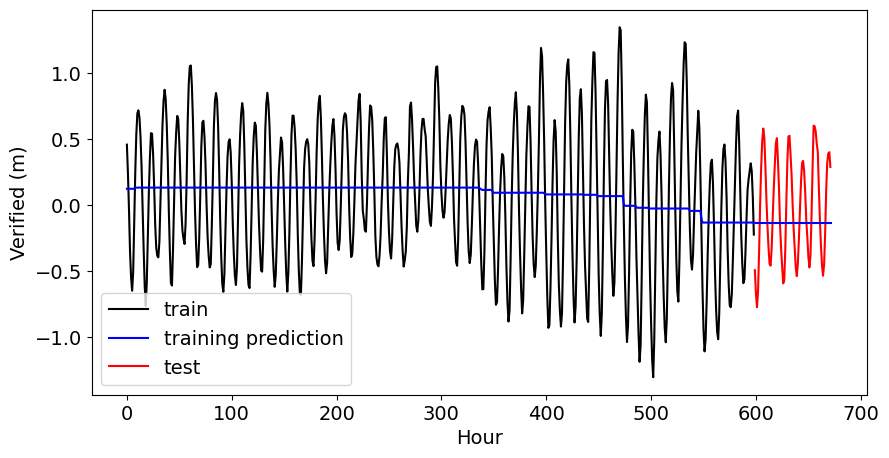

In [121]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_train,y_pred_train_rf,color='blue', label = 'training prediction')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(arr,y_trend,color='blue')
ax.set_xlabel('Hour')
ax.set_ylabel('Verified (m)')
ax.legend()

In [122]:
plt.rcParams.update({'font.size': 16})

In [123]:
residual_train = y_train - y_pred_train_rf
residual_test = y_test - y_pred_test_rf

In [124]:
opt = gpflow.optimizers.Scipy()

In [125]:
k = gpflow.kernels.Exponential(0.1,3) 
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\2754874951.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)


In [126]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 21.54015709022292
        x: [ 3.867e+00 -1.143e+00 -2.186e+01]
      nit: 30
      jac: [ 5.400e-05 -1.330e-04  2.271e-06]
     nfev: 35
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [127]:
print_summary(gp_mdl)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.2767  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.88741 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0       │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [128]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.00000
test error 0.16150


In [129]:
x_new = np.linspace(0,672,125)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis]) # it returns the mean and std of the GP prediction
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict(x_new[:,np.newaxis])
mu = trend + residual

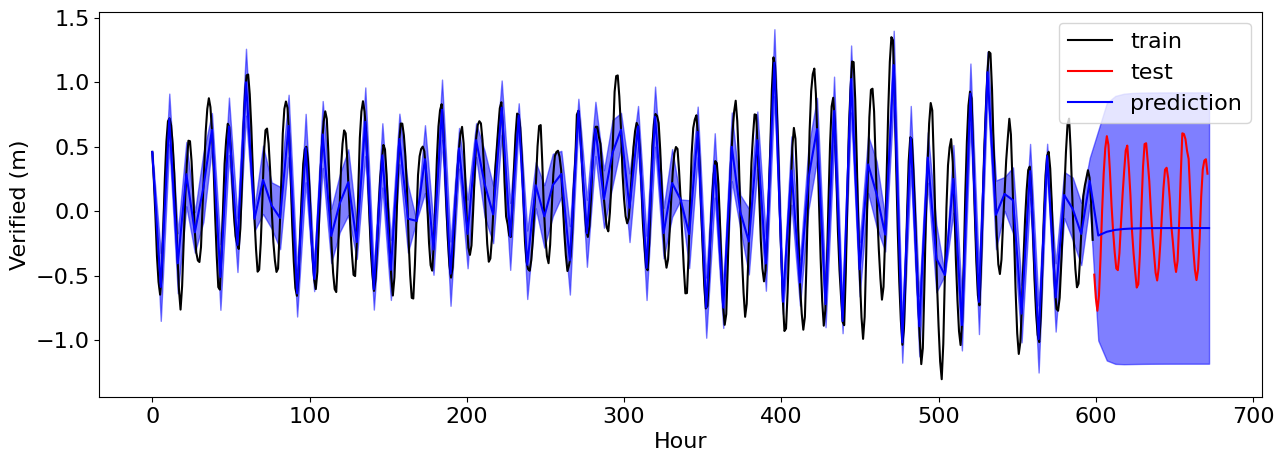

In [130]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5) # show prediction error
ax.set_xlabel('Hour')
ax.set_ylabel('Verified (m)')
ax.legend()

In [131]:
opt = gpflow.optimizers.Scipy()
k = gpflow.kernels.Periodic(gpflow.kernels.Exponential(0.1,4))
gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)

C:\Users\Holt Leach\AppData\Local\Temp\ipykernel_35276\3834780370.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gp_mdl = gpflow.models.GPR(data=(X_train.astype(np.float64), residual_train[:,np.newaxis]), kernel= k)


In [132]:
opt_logs = opt.minimize(gp_mdl.training_loss, gp_mdl.trainable_variables, options=dict(maxiter=300))
opt_logs

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 78.78715159349281
        x: [ 1.287e+00  2.493e+00  3.477e+00 -2.913e+00]
      nit: 38
      jac: [ 7.691e-01  1.799e-01  4.664e-02 -1.771e-04]
     nfev: 67
     njev: 67
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [133]:
print_summary(gp_mdl)

╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.50736 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.57198 │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.5308  │


In [134]:
mu, _ = gp_mdl.predict_f(X_train.astype(np.float64))
print(f'training error {mean_squared_error(residual_train,mu):.5f}')
mu, _ = gp_mdl.predict_f(X_test.astype(np.float64))
print(f'test error {mean_squared_error(residual_test,mu):.5f}')

training error 0.04342
test error 0.04373


In [135]:
x_new = np.linspace(0,672,100)
residual, var = gp_mdl.predict_f(x_new[:,np.newaxis])
residual = residual.numpy().flatten()
std = np.sqrt(var.numpy().flatten())
trend = rfMdl.predict(x_new[:,np.newaxis])
mu = trend + residual

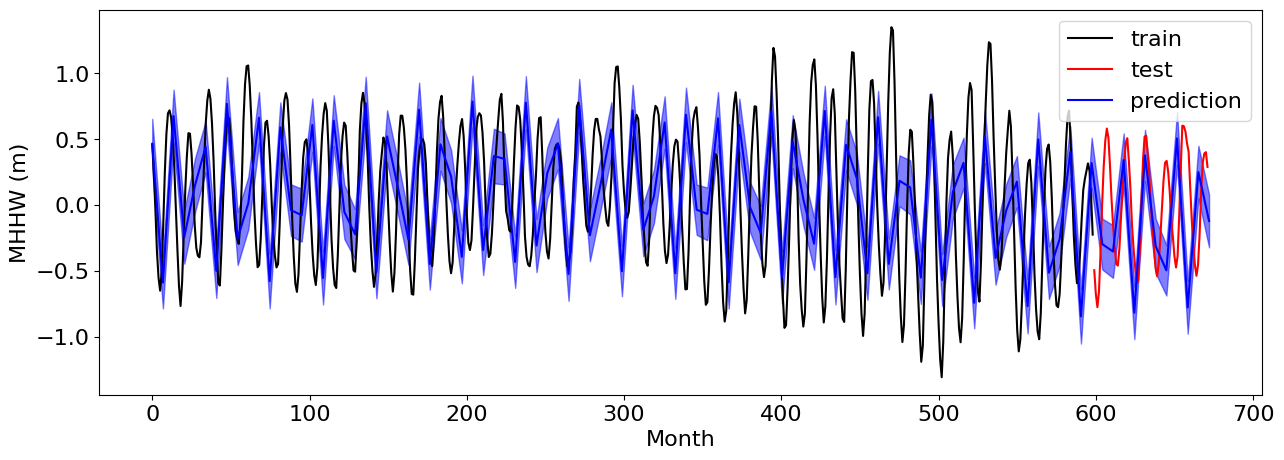

In [136]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(X_train,y_train,color='k',label='train')
ax.plot(X_test,y_test,color='red',label='test')
ax.plot(x_new,mu,color='blue',label='prediction')
ax.fill_between(x_new, (mu-2*std), (mu+2*std), color='b',alpha=0.5) 
ax.set_xlabel('Month')
ax.set_ylabel('MHHW (m)')
ax.legend()